In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
training_csv='./melanoma-image-data/train.csv'
test_csv='./melanoma-image-data/test.csv'
train_dataframe=pd.read_csv(training_csv)
test_dataframe=pd.read_csv(test_csv)
train_dataframe.head(7)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0
5,ISIC_0074311,IP_2950485,female,40.0,lower extremity,unknown,benign,0
6,ISIC_0074542,IP_4698288,male,25.0,lower extremity,unknown,benign,0


In [3]:
train_dataframe['target'].value_counts()

0    32542
1      584
Name: target, dtype: int64

In [4]:
benign_data=train_dataframe[train_dataframe['target']==0]
maligant_data=train_dataframe[train_dataframe['target']==1]

benign_data=benign_data.reset_index()
maligant_data=maligant_data.reset_index()

print(benign_data.shape[0])
print(maligant_data.shape[0])

32542
584


In [5]:
#train_bening_data
train_benign_dir='./melanoma-image-data/train/train/benign/'
data_benign = []
labels_benign =[]


train_maligant_dir='./melanoma-image-data/train/train/malignant/'
data_maligant = []
labels_maligant =[]

for i in range(benign_data.shape[0]):
    data_benign.append(train_benign_dir+benign_data['image_name'].iloc[i]+'.jpg')
    labels_benign.append(benign_data['target'].iloc[i])
df_benign=pd.DataFrame(data_benign)
df_benign.columns=['images']
df_benign['target']=labels_benign


for i in range(maligant_data.shape[0]):
    data_maligant.append(train_maligant_dir+maligant_data['image_name'].iloc[i]+'.jpg')
    labels_maligant.append(maligant_data['target'].iloc[i])
df_maligant=pd.DataFrame(data_maligant)
df_maligant.columns=['images']
df_maligant['target']=labels_maligant

print(df_benign.shape)
print(df_maligant.shape)

df=pd.concat([df_benign,df_maligant])
df.shape

(32542, 2)
(584, 2)


(33126, 2)

In [6]:
test_dir='./melanoma-image-data/test/test/unkown/'
test_data = []
for i in range(test_dataframe.shape[0]):
    test_data.append(test_dir + test_dataframe['image_name'].iloc[i]+'.jpg')
df_test_kaggle=pd.DataFrame(test_data)
df_test_kaggle.columns=['images']
df_test_kaggle.shape
df_test_kaggle

,images
0,./melanoma-image-data/test/test/unkown/ISIC_00...
1,./melanoma-image-data/test/test/unkown/ISIC_00...
2,./melanoma-image-data/test/test/unkown/ISIC_00...
3,./melanoma-image-data/test/test/unkown/ISIC_00...
4,./melanoma-image-data/test/test/unkown/ISIC_00...
...,...
10977,./melanoma-image-data/test/test/unkown/ISIC_99...
10978,./melanoma-image-data/test/test/unkown/ISIC_99...
10979,./melanoma-image-data/test/test/unkown/ISIC_99...
10980,./melanoma-image-data/test/test/unkown/ISIC_99...


In [7]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(df['images'],df['target'],test_size=0.2,random_state=42,stratify=df['target'])

train_gen = pd.DataFrame({'image_dir': x_train, 'target': y_train})
val_gen = pd.DataFrame({'image_dir': x_val, 'target': y_val})

In [8]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(train_gen['image_dir'],train_gen['target'],test_size=0.1,random_state=42,stratify=train_gen['target'])

y_test_conf=y_test
train_gen = pd.DataFrame({'image_dir': x_train, 'target': y_train})
test_gen = pd.DataFrame({'image_dir': x_test, 'target': y_test})

In [9]:
!pip install livelossplot

In [9]:
from keras.layers import Input,Lambda,Dense,Flatten,Conv2D, MaxPooling2D, Dropout
from keras.applications.xception import Xception,preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from glob import glob

from keras.layers import Dense, Flatten
from tensorflow.keras import layers
from keras.metrics import AUC
from keras.activations import sigmoid
from keras.models import Model,load_model

from keras.optimizers import Adam
import tensorflow as tf


from tensorflow.python.keras import backend as K
from livelossplot import PlotLossesKeras

2023-03-19 20:37:48.332954: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-19 20:37:48.512126: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-19 20:37:48.512193: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-19 20:37:49.620907: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [10]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range = 0.2,
                                   fill_mode ='nearest',
                                   horizontal_flip=True)
val_datagen=ImageDataGenerator(preprocessing_function =preprocess_input)
test_datagen =ImageDataGenerator(preprocessing_function =preprocess_input)


train_generator = train_datagen.flow_from_dataframe(
    train_gen,
    x_col='image_dir',
    y_col='target',
    target_size=(224, 224),
    batch_size=64,
    class_mode='raw')

validation_generator = val_datagen.flow_from_dataframe(
    val_gen,
    x_col='image_dir',
    y_col='target',
    target_size=(224, 224),
    batch_size=64,
    class_mode='raw')




Found 23850 validated image filenames.
Found 6626 validated image filenames.


In [11]:

base_model= Xception(weights='imagenet',input_shape=(224,224,3),include_top=False)

for layer in base_model.layers:
    layer.trainable = False
    
layer_top=Flatten()(base_model.output)
layer_top=layers.Dense(1, activation = 'sigmoid')(layer_top)

model =Model(inputs=base_model.input,outputs=layer_top)
#model.summary()

2023-03-19 20:37:59.179490: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-19 20:37:59.179542: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-19 20:37:59.179582: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (skin-cancer-v2): /proc/driver/nvidia/version does not exist
2023-03-19 20:37:59.179913: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
opt = Adam(lr=1e-4)
auc = tf.keras.metrics.AUC()
model.compile(loss='binary_crossentropy', metrics=[auc],optimizer=opt)

In [37]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint,EarlyStopping



mc = ModelCheckpoint(filepath='Xception_Imbalanced_AUC_model1.h5',
                     monitor='auc_3',  # even use the generated handle for monitoring the training AUC
                     save_best_only=True,
                     mode='max')

#Early stopping
es = EarlyStopping(monitor = 'auc_3', patience = 3, mode='max',min_delta = 0.01)

callbacks = [mc,es]

start = datetime.now()


model.fit_generator(
    train_generator,
    steps_per_epoch=372,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks,
    validation_steps=100,
     verbose=1

)



duration = datetime.now() - start
print("Training completed in time: ", duration)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
372/372 [==============================] - 2909s 8s/step - loss: 0.0825 - auc_2: 0.7726 - val_loss: 0.0807 - val_auc_2: 0.7612
Epoch 2/30
372/372 [==============================] - 2887s 8s/step - loss: 0.0807 - auc_2: 0.7816 - val_loss: 0.0947 - val_auc_2: 0.7016
Epoch 3/30
372/372 [==============================] - 2917s 8s/step - loss: 0.0800 - auc_2: 0.7988 - val_loss: 0.0965 - val_auc_2: 0.8115
Epoch 4/30
372/372 [==============================] - 2867s 8s/step - loss: 0.0786 - auc_2: 0.8089 - val_loss: 0.0827 - val_auc_2: 0.7542
Epoch 5/30
372/372 [==============================] - 2926s 8s/step - loss: 0.0778 - auc_2: 0.8153 - val_loss: 0.0823 - val_auc_2: 0.7679
Epoch 6/30
372/372 [==============================] - 2924s 8s/step - loss: 0.0782 - auc_2: 0.8065 - val_loss: 0.0781 - val_auc_2: 0.8269
Epoch 7/30
372/372 [==============================] - 2881s 8s/step - loss: 0.0747 - auc_2: 0.8212 - val_loss: 0.0894 - val_auc_2: 0.7377
Epoch 8/30
372/372 [==============

In [38]:
# Load best fit model
imbalanced_model = load_model('Xception_Imbalanced_AUC_model1.h5')

results = imbalanced_model.evaluate_generator(generator=test_generator,verbose = 1)
print(" Test loss and accuracy are", results)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  after removing the cwd from sys.path.


42/42 [==============================] - 235s 6s/step - loss: 0.0979 - auc_2: 0.7065
 Test loss and accuracy are [0.09789910167455673, 0.7065211534500122]


In [13]:
test_generator = test_datagen.flow_from_dataframe(
    test_gen,
    x_col='image_dir',
    y_col='target',
    target_size=(224, 224),
    batch_size=64,
    class_mode='raw',
    shuffle=False
)

Found 2650 validated image filenames.


In [119]:
# Get prediction
imbalanced_pred = imbalanced_model.predict(test_generator,verbose = 1)
print(imbalanced_pred)

42/42 [==============================] - 234s 6s/step
[[2.6630313e-04]
 [2.4012669e-03]
 [3.1957385e-04]
 ...
 [3.5092616e-03]
 [2.5958816e-05]
 [4.6575259e-02]]


In [90]:
import math

In [102]:
test_gen.target

19704    0
30758    0
10912    0
9964     0
8051     0
        ..
5358     0
6908     0
1119     0
28291    0
32541    0
Name: target, Length: 2650, dtype: int64

In [115]:
test_gen['target'].value_counts()

0    2603
1      47
Name: target, dtype: int64

In [117]:
y_test = np.array([])
num_batches = 0
for _, y in test_generator:
    y_test = np.append(y_test, y)
    num_batches += 1
    if num_batches == math.ceil(2650//64):
        break
y_test

array([0., 0., 0., ..., 0., 0., 0.])

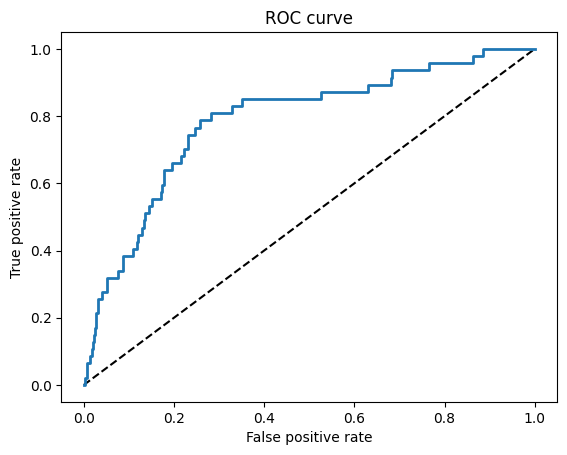

Area under curve, AUC =  0.7879124741501213


In [121]:
from sklearn.metrics import roc_curve


fpr, tpr, thresholds = roc_curve(test_gen.target, imbalanced_pred)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, linewidth = 2, label = None)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)



# process kaggle dataset

In [32]:

kaggle_test_path='./melanoma-image-data/test/test'
test_set_kaggle = test_datagen.flow_from_directory(kaggle_test_path,
                                             target_size = (224,224),
                                             batch_size = 64,
                                             class_mode = 'categorical',
                                             shuffle=False)

test_set_kaggle.reset()

Found 10982 images belonging to 1 classes.


In [136]:
kaggle_pred_test = imbalanced_model.predict_generator(test_set_kaggle,verbose=1)
print(kaggle_pred_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


172/172 [==============================] - 905s 5s/step
[[3.7437243e-05]
 [2.7310030e-05]
 [1.2810072e-03]
 ...
 [2.0076777e-03]
 [1.5700646e-04]
 [1.6786133e-04]]


In [137]:
# Malignent Prediction
imbalanced_predict_malignent=[]
for i in range(len(kaggle_pred_test)):
    imbalanced_predict_malignent.append(1-kaggle_pred_test[i]) 

#print(imbalanced_predict_class_kaggle)
imbalanced_np_malignent=np.asarray(imbalanced_predict_malignent, dtype=None)
imbalanced_np_malignent=imbalanced_np_malignent.ravel()

In [138]:
import pandas as pd
filenames=test_set_kaggle.filenames
results=pd.DataFrame({"image_name":filenames,
                      "target":imbalanced_np_malignent})
results.to_csv("Xception_imbalanced_final_results_kaggle.csv",index=False)

# class balanced focal loss

In [45]:
train_gen['target'].value_counts()

0    23430
1      420
Name: target, dtype: int64

In [46]:
def calculate_alpha(beta = 0.999):
     bening_sample=[23430,420]
     effective_num=1-np.power(beta,bening_sample)
     weights=(1.0-beta)/np.array(effective_num)
     weights=weights/np.sum(weights)*2
     return weights

alpha=calculate_alpha()
print(alpha[0])
print(alpha[1])

0.5108978868851661
1.4891021131148336


In [59]:
opt = Adam(lr=0.0001)
auc = tf.keras.metrics.AUC()

model.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(
    alpha=alpha[0],
    gamma=1),
    optimizer = opt,
    metrics =[auc])

In [61]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint,EarlyStopping



mc = ModelCheckpoint(filepath='Xception_focal_AUC_model1.h5',
                     monitor='auc_6',  # even use the generated handle for monitoring the training AUC
                     save_best_only=True,
                     mode='max')

#Early stopping
es = EarlyStopping(monitor = 'auc_6', patience = 3, mode='max',min_delta = 0.01)

callbacks = [mc,es]

start = datetime.now()


model.fit_generator(
    train_generator,
    steps_per_epoch=372,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks,
    validation_steps=100,
    verbose=1

)



duration = datetime.now() - start
print("Training completed in time: ", duration)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
372/372 [==============================] - 2906s 8s/step - loss: 0.0493 - auc_6: 0.8464 - val_loss: 0.0540 - val_auc_6: 0.7810
Epoch 2/30
372/372 [==============================] - 2929s 8s/step - loss: 0.0491 - auc_6: 0.8314 - val_loss: 0.0593 - val_auc_6: 0.7613
Epoch 3/30
372/372 [==============================] - 2840s 8s/step - loss: 0.0446 - auc_6: 0.8414 - val_loss: 0.0605 - val_auc_6: 0.7469
Epoch 4/30
372/372 [==============================] - 2907s 8s/step - loss: 0.0493 - auc_6: 0.8205 - val_loss: 0.0628 - val_auc_6: 0.7569
Training completed in time:  3:13:06.864298


In [62]:
#load best model
from keras.models import load_model

# Load best fit model
focalloss_model = load_model('Xception_focal_AUC_model1.h5')

results = focalloss_model.evaluate_generator(generator=test_generator,verbose = 1)
print(" Test loss and accuracy are", results)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  import sys


42/42 [==============================] - 222s 5s/step - loss: 0.0578 - auc_6: 0.7697
 Test loss and accuracy are [0.05781017243862152, 0.7696970105171204]


In [122]:

focal_pred = focalloss_model.predict(test_generator,verbose = 1)
print(focal_pred)

42/42 [==============================] - 236s 6s/step
[[0.00290892]
 [0.02386485]
 [0.00778354]
 ...
 [0.19264562]
 [0.00239917]
 [0.12711811]]


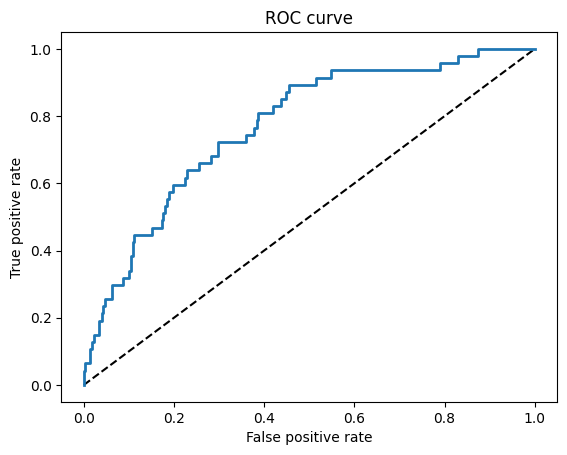

Area under curve, AUC =  0.7707309896110052


In [139]:
from sklearn.metrics import roc_curve


fpr, tpr, thresholds = roc_curve(test_gen.target, focal_pred)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, linewidth = 2, label = None)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)

In [140]:
kaggle_pred_test = focalloss_model.predict_generator(test_set_kaggle,verbose=1)
print(kaggle_pred_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


172/172 [==============================] - 893s 5s/step
[[0.00104287]
 [0.00717582]
 [0.02538784]
 ...
 [0.12838204]
 [0.01767003]
 [0.04937518]]


In [141]:
# Malignent Prediction
focalloss_predict_malignent=[]
for i in range(len(kaggle_pred_test)):
    focalloss_predict_malignent.append(1-kaggle_pred_test[i]) 

#print(imbalanced_predict_class_kaggle)
focalloss_np_malignent=np.asarray(focalloss_predict_malignent, dtype=None)
focalloss_np_malignent=focalloss_np_malignent.ravel()

In [142]:
import pandas as pd
filenames=test_set_kaggle.filenames
results=pd.DataFrame({"image_name":filenames,
                      "target":focalloss_np_malignent})
results.to_csv("Xception_focalloss_resultsV1.csv",index=False)

# balanced using inverse class frequency

In [69]:
opt = Adam(lr=0.0001)
auc = tf.keras.metrics.AUC()
model.compile(loss='binary_crossentropy', metrics=[auc],optimizer=opt)

In [70]:
x_train, y_train=next(train_generator)

In [80]:
train_classes=y_train
from sklearn.utils import compute_class_weight

class_weights = compute_class_weight(
                                        class_weight = 'balanced',
                                        classes = np.unique(train_classes),
                                        y = train_classes
) 
class_weights = dict(zip(np.unique(train_classes),class_weights))
class_weights

{0: 0.5089628681177977, 1: 28.392857142857142}

In [82]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint,EarlyStopping



mc = ModelCheckpoint(filepath='Xception_balanced_inverse_AUC_model1.h5',
                     monitor='auc_8',  # even use the generated handle for monitoring the training AUC
                     save_best_only=True,
                     mode='max')

#Early stopping
es = EarlyStopping(monitor = 'auc_8', patience = 3, mode='max',min_delta = 0.01)

callbacks = [mc,es]

start = datetime.now()


model.fit_generator(
    train_generator,
    steps_per_epoch=372,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks,
    validation_steps=100,
    class_weight=class_weights,
     verbose=1

)



duration = datetime.now() - start
print("Training completed in time: ", duration)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
372/372 [==============================] - 2933s 8s/step - loss: 0.5201 - auc_8: 0.8461 - val_loss: 0.2571 - val_auc_8: 0.7825
Epoch 2/30
372/372 [==============================] - 3026s 8s/step - loss: 0.4935 - auc_8: 0.8641 - val_loss: 0.2988 - val_auc_8: 0.8110
Epoch 3/30
372/372 [==============================] - 3047s 8s/step - loss: 0.5559 - auc_8: 0.8501 - val_loss: 0.2312 - val_auc_8: 0.8240
Epoch 4/30
372/372 [==============================] - 3017s 8s/step - loss: 0.4858 - auc_8: 0.8697 - val_loss: 0.8201 - val_auc_8: 0.7966
Epoch 5/30
372/372 [==============================] - 3076s 8s/step - loss: 0.5428 - auc_8: 0.8581 - val_loss: 0.5069 - val_auc_8: 0.7964
Training completed in time:  4:11:48.398087


In [126]:
#load best model
from keras.models import load_model

# Load best fit model
weighted_model = load_model('Xception_balanced_inverse_AUC_model1.h5')

results = weighted_model.evaluate_generator(generator=test_generator,verbose = 1)
print(" Test loss and accuracy are", results)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  import sys


42/42 [==============================] - 248s 6s/step - loss: 0.8577 - auc_8: 0.7740
 Test loss and accuracy are [0.8577170372009277, 0.7739678025245667]


In [124]:
balanced_pred = weighted_model.predict(test_generator,verbose = 1)
print(balanced_pred)

42/42 [==============================] - 236s 6s/step
[[0.43849343]
 [0.35091457]
 [0.03907391]
 ...
 [0.41689116]
 [0.00502644]
 [0.99748236]]


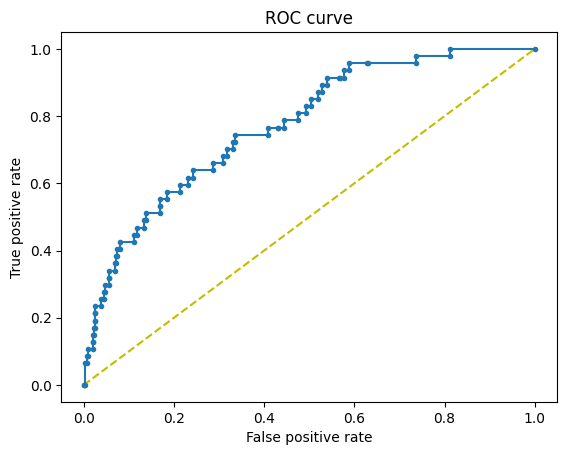

Area under curve, AUC =  0.7742621034649054


In [125]:
from sklearn.metrics import roc_curve


fpr, tpr, thresholds = roc_curve(test_gen.target, balanced_pred)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)

In [143]:
kaggle_pred_test = weighted_model.predict_generator(test_set_kaggle,verbose=1)
print(kaggle_pred_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


172/172 [==============================] - 826s 5s/step
[[0.01317419]
 [0.08964346]
 [0.11958716]
 ...
 [0.83931553]
 [0.2948755 ]
 [0.4836124 ]]


In [144]:
# Malignent Prediction
weighted_predict_malignent=[]
for i in range(len(kaggle_pred_test)):
    weighted_predict_malignent.append(1-kaggle_pred_test[i]) 

#print(imbalanced_predict_class_kaggle)
weighted_predict_malignent=np.asarray(weighted_predict_malignent, dtype=None)
weighted_predict_malignent=weighted_predict_malignent.ravel()

In [145]:
import pandas as pd
filenames=test_set_kaggle.filenames
results=pd.DataFrame({"image_name":filenames,
                      "target":weighted_predict_malignent})
results.to_csv("xception_weighted_resultsV1.csv",index=False)

# Model with average / sum Ensemble

In [14]:

from keras.models import load_model
from sklearn.metrics import accuracy_score


model1 = load_model('Xception_focal_AUC_model1.h5')
model2 = load_model('Xception_balanced_inverse_AUC_model1.h5')


models = [model1, model2]

preds = [model.predict(test_generator) for model in models]
preds=np.array(preds)



42/42 [==============================] - 240s 6s/step


In [27]:
weights = [0.1, 0.9]

In [28]:
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.average(weighted_preds, axis=1)
print(weighted_ensemble_prediction)

[0.39493498 0.3182096  0.03594488 ... 0.3944666  0.00476371 0.91044593]


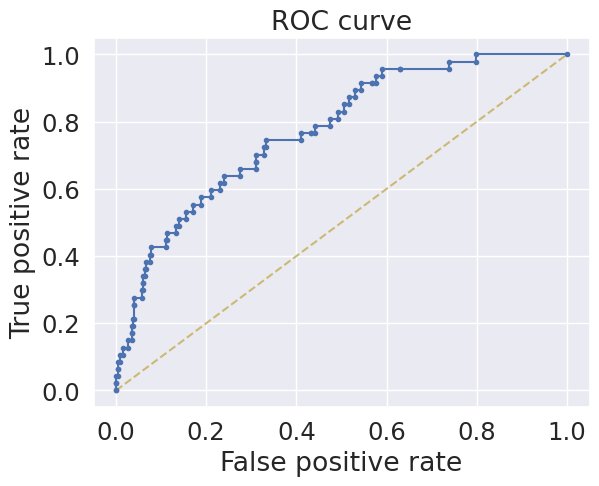

Area under curve, AUC =  0.7741067998463312


In [29]:
from sklearn.metrics import roc_curve


fpr, tpr, thresholds = roc_curve(test_gen.target, weighted_ensemble_prediction)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)

In [30]:
balanced_pred_conf=weighted_ensemble_prediction
for i in range(len(balanced_pred_conf)):
    if (balanced_pred_conf[i]>0.5):
        balanced_pred_conf[i] = 1
    else:
        balanced_pred_conf[i] = 0
balanced_pred_conf

array([0., 0., 0., ..., 0., 0., 1.])

<AxesSubplot:>

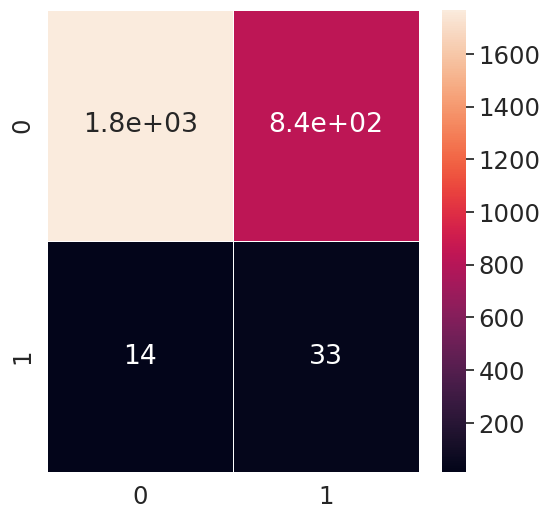

In [31]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test_conf, weighted_ensemble_prediction)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

In [33]:
kaggle_pred_test= [model.predict(test_set_kaggle,verbose=1) for model in models]
kaggle_pred_test=np.array(kaggle_pred_test)

weights = [0.1, 0.9]
weighted_preds = np.tensordot(kaggle_pred_test, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.average(weighted_preds, axis=1)
print(weighted_ensemble_prediction)

172/172 [==============================] - 872s 5s/step
[0.01196106 0.0813967  0.11016723 ... 0.76822218 0.26715496 0.44018867]


In [34]:
ensemble_predict_malignent=np.asarray(weighted_ensemble_prediction, dtype=None)
ensemble_predict_malignent=ensemble_predict_malignent.ravel()

import pandas as pd
filenames=test_set_kaggle.filenames
results=pd.DataFrame({"image_name":filenames,
                      "target":ensemble_predict_malignent})
results.to_csv("Xception_Ensemble_results_final.csv",index=False)